# CaBi ML fitting - Random Forest - Total rides

In this notebook I use RandomForestRegressor to fit on our training data, 1/1/2013 to 9/8/2017, score the model using 5-fold cross-validation, then predict on our test data, 9/9/2017 to 4/30/2018.

Dependent variable = total DC to DC CaBi rides.


# 0. Data load, shaping, and split

* Read in data from AWS
  * Check for high pairwise correlation
* Encode time variable (day_of_year) as cyclical
* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Specify feature and target columns

In [1]:
# Read in data from AWS

from util_functions import *
import numpy as np
import pandas as pd
from pprint import pprint
import time

start_time = time.perf_counter()

set_env_path()
conn, cur = aws_connect()

# fullquery contains pretty much everything

fullquery = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
year,
quarter,
month,
day_of_week,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturehightime,
apparenttemperaturelow,
apparenttemperaturelowtime,
precipintensitymaxtime,
sunrisetime,
sunsettime,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
nats_attendance,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_dur_empty_wdc,
cabi_dur_full_wdc,
cabi_dur_empty_arl,
cabi_dur_full_arl,
cabi_dur_full_alx,
cabi_dur_empty_alx,
cabi_dur_empty_mcs,
cabi_dur_full_mcs,
cabi_dur_full_mcn,
cabi_dur_empty_mcn,
cabi_dur_full_ffx,
cabi_dur_empty_ffx,
cabi_dur_empty_tot,
cabi_dur_full_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
year,
quarter,
month,
day_of_week,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturehightime,
apparenttemperaturelow,
apparenttemperaturelowtime,
precipintensitymaxtime,
sunrisetime,
sunsettime,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
nats_attendance,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

print("We have {} instances and {} features".format(*df.shape))

We have 2780 instances and 50 features


#### Summary statistics

In [2]:
df.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
day_of_year,2780.0,182.697,107.702,1.000,182.000,366.000
year,2780.0,2014.024,2.228,2010.000,2014.000,2018.000
quarter,2780.0,2.505,1.140,1.000,3.000,4.000
month,2780.0,6.507,3.522,1.000,7.000,12.000
day_of_week,2780.0,2.999,2.000,0.000,3.000,6.000
daylight_hours,2780.0,12.077,2.021,9.000,12.000,15.000
apparenttemperaturehigh,2780.0,64.306,20.594,2.240,65.890,113.670
apparenttemperaturehightime,2780.0,15.460,2.352,7.000,16.000,19.000
apparenttemperaturelow,2780.0,48.574,19.685,-10.840,50.885,90.060
apparenttemperaturelowtime,2780.0,6.783,4.354,0.000,6.000,23.000


In [3]:
df.tail()

,day_of_year,date,year,quarter,month,day_of_week,daylight_hours,apparenttemperaturehigh,apparenttemperaturehightime,apparenttemperaturelow,apparenttemperaturelowtime,precipintensitymaxtime,sunrisetime,sunsettime,cloudcover,dewpoint,humidity,precipaccumulation,precipintensitymax,precipprobability,rain,snow,visibility,windspeed,us_holiday,nats_single,nats_double,nats_attendance,dc_bike_event,dc_pop,cabi_bikes_avail,cabi_stations_alx,cabi_stations_arl,cabi_stations_ffx,cabi_stations_mcn,cabi_stations_mcs,cabi_stations_wdc,cabi_docks_alx,cabi_docks_arl,cabi_docks_ffx,cabi_docks_mcn,cabi_docks_mcs,cabi_docks_wdc,cabi_stations_tot,cabi_docks_tot,cabi_active_members_day_key,cabi_active_members_monthly,cabi_active_members_annual,cabi_trips_wdc_to_wdc,cabi_trips_wdc_to_wdc_casual
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-26,116.0,2018-04-26,2018.0,2.0,4.0,4.0,13.0,69.70,18.0,53.46,5.0,19.0,6.0,19.0,0.13,40.65,0.51,0.0,0.0000,0.0,0.0,0.0,9.98,6.25,0.0,0.0,0.0,0.0,0.0,702021.56174,4350.0,31.0,92.0,25.0,35.0,45.0,268.0,650.0,1611.0,442.0,764.0,894.0,5820.0,496.0,10181.0,16216.0,214.0,33903.0,11949.0,2779.0
2018-04-27,117.0,2018-04-27,2018.0,2.0,4.0,5.0,13.0,61.85,18.0,47.66,6.0,5.0,6.0,19.0,0.46,50.50,0.80,0.0,0.1564,1.0,1.0,0.0,8.59,2.89,0.0,1.0,0.0,26517.0,0.0,702021.56174,4351.0,31.0,92.0,25.0,35.0,45.0,268.0,650.0,1611.0,442.0,764.0,894.0,5820.0,496.0,10181.0,16216.0,214.0,33903.0,8985.0,2245.0
2018-04-28,118.0,2018-04-28,2018.0,2.0,4.0,6.0,13.0,75.37,16.0,38.95,6.0,23.0,6.0,19.0,0.27,48.20,0.69,0.0,0.0034,0.2,1.0,0.0,8.44,1.21,0.0,1.0,0.0,32963.0,0.0,702021.56174,4353.0,31.0,92.0,25.0,35.0,46.0,268.0,650.0,1611.0,442.0,764.0,909.0,5820.0,497.0,10196.0,16216.0,214.0,33903.0,12946.0,5955.0
2018-04-29,119.0,2018-04-29,2018.0,2.0,4.0,0.0,13.0,54.68,17.0,34.37,6.0,1.0,6.0,19.0,0.28,31.67,0.49,0.0,0.0010,0.1,1.0,0.0,10.00,13.66,0.0,1.0,0.0,30285.0,0.0,702021.56174,4353.0,31.0,92.0,25.0,35.0,46.0,268.0,650.0,1611.0,442.0,764.0,909.0,5820.0,497.0,10196.0,16216.0,214.0,33903.0,7838.0,2741.0
2018-04-30,120.0,2018-04-30,2018.0,2.0,4.0,1.0,14.0,71.27,17.0,41.36,6.0,19.0,6.0,20.0,0.07,26.42,0.39,0.0,0.0000,0.0,0.0,0.0,10.00,9.61,0.0,1.0,0.0,20879.0,0.0,702021.56174,4353.0,31.0,92.0,25.0,35.0,46.0,268.0,650.0,1611.0,442.0,764.0,909.0,5820.0,497.0,10196.0,16216.0,214.0,33903.0,10543.0,2196.0


In [4]:
def print_highly_correlated(df, features, threshold=0.75):
    """ 
    Prints highly correlated feature pairs in df. Threshold set at 0.75 by default.
    Selects pairs where abs(r) is above the threshold, puts them in a DataFrame,
    making sure to avoid duplication, then sorts by abs(r) and prints.
    """
    corr_df = df[features].corr()
    correlated_features = np.where(np.abs(corr_df) > threshold)
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y]
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0]))
    print("There are {} feature pairs with pairwise correlation above {}".format(len(s_corr_list), threshold))
    for v, i, j in s_corr_list:
        cols = df[features].columns
        print("{} and {} = {:0.3f}".format(corr_df.index[i], corr_df.columns[j], v))
        
print_highly_correlated(df, df.columns)

There are 153 feature pairs with pairwise correlation above 0.75
cabi_stations_mcs and cabi_docks_mcs = 1.000
cabi_stations_tot and cabi_docks_tot = 1.000
cabi_stations_ffx and cabi_docks_ffx = 0.999
cabi_stations_wdc and cabi_docks_wdc = 0.999
cabi_stations_arl and cabi_docks_arl = 0.998
cabi_stations_mcn and cabi_docks_mcn = 0.997
day_of_year and month = 0.997
cabi_stations_wdc and cabi_docks_tot = 0.994
cabi_stations_wdc and cabi_stations_tot = 0.994
cabi_docks_wdc and cabi_docks_tot = 0.993
cabi_bikes_avail and cabi_stations_tot = 0.992
cabi_docks_wdc and cabi_stations_tot = 0.991
cabi_bikes_avail and cabi_docks_tot = 0.991
cabi_stations_alx and cabi_docks_alx = 0.990
dc_pop and cabi_docks_arl = 0.989
cabi_stations_mcn and cabi_stations_mcs = 0.988
dc_pop and cabi_docks_tot = 0.988
cabi_bikes_avail and cabi_stations_wdc = 0.988
dc_pop and cabi_stations_wdc = 0.988
dc_pop and cabi_docks_wdc = 0.987
dc_pop and cabi_stations_tot = 0.986
dc_pop and cabi_bikes_avail = 0.986
cabi_station

#### Encode day of year as cyclical

In [5]:
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

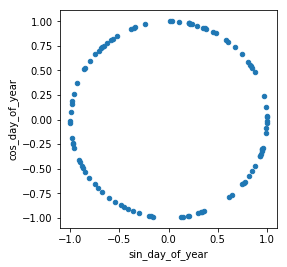

In [6]:
%matplotlib inline

df.sample(100).plot.scatter('sin_day_of_year','cos_day_of_year').set_aspect('equal')

* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Training dates = 2013-01-01 to 2017-09-08
  * Test dates = 2017-09-09 to 2018-04-30
    * Coincides with dockless pilot

In [7]:
train = df.loc['2013-01-01':'2017-09-08']
test = df.loc['2017-09-09':'2018-04-30']
print(train.shape, test.shape)

tr = train.shape[0]
te = test.shape[0]
trpct = tr/(tr+te)
tepct = te/(tr+te)

print("{:0.3f} percent of the data is in the training set and {:0.3f} percent is in the test set".format(trpct, tepct))

(1712, 52) (234, 52)
0.880 percent of the data is in the training set and 0.120 percent is in the test set


In [8]:
# Specify columns to keep and drop for X and y
drop_cols = ['date']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain = train[feature_cols]

# Our target variable here is all DC to DC trips
ytrain = train[y_cols[0]]
Xtest = test[feature_cols]
ytest = test[y_cols[0]]
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(1712, 49) (1712,) (234, 49) (234,)


# 1. Model Hyperparameter Tuning

* Scoring functions
* RandomizedSearchCV
* GridSearchCV
  * Compare GridSearch and RandomizedSearch scores and parameters

In [9]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def score_model(model):
    """ 
    Fits a model using the training set, predicts using the test set, and then calculates 
    and reports goodness of fit metrics.
    """
    model.fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    r2 = r2_score(ytest, yhat)
    me = mse(ytest, yhat)
    print("Results from {}: \nr2={:0.3f} \nMSE={:0.3f}".format(model, r2, me))

def cv_score(model, n_splits=5):
    """
    Evaluates a model by 5-fold cross-validation and prints mean and 2*stdev of scores.
    Shuffles before cross-validation but sets random_state=7 for reproducibility.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=7)
    scores = cross_val_score(model, Xtrain, ytrain, cv=kf, 
                             scoring=None,
                             n_jobs=-1, verbose=3)
    print(scores)
    print("R^2: {:0.3f} (+/- {:0.3f})".format(scores.mean(), scores.std() * 2))

#### RandomizedSearchCV

We need to find appropriate values for our hyperparameters.

We can start by using RandomizedSearchCV to cast a wide net.

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the parameter grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Altogether, there are 10 * 2 * 12 * 3 * 4 * 2 = 5760 combinations.

We randomly sample 100 times per fold for a total of 500 fits.

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5-fold cross-validation, 
# search across 100 different combinations, and use all available cores
cv = KFold(n_splits=5, shuffle=True, random_state=7)
ran_search = RandomizedSearchCV(estimator=rf, 
                               param_distributions=param_distributions,
                               scoring=None,
                               n_iter=100, cv=cv, verbose=3, 
                               random_state=7, n_jobs=-1)

# Fit the random search model
ran_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 23.5min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

We're interested in seeing if there's any improvement between the untuned default RF model and our new one.

In [12]:
rf_random = ran_search.best_estimator_

print("Cross-validation score for base RF")
cv_score(rf)

print("\nCross-validation score for RF tuned by RandomizedSearchCV")
cv_score(rf_random)
print()

# What parameters are used?
pprint(ran_search.best_params_)

Cross-validation score for base RF


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


[0.87927966 0.88035876 0.88177413 0.88911985 0.88812261]
R^2: 0.884 (+/- 0.008)

Cross-validation score for RF tuned by RandomizedSearchCV


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.1s


[0.90419977 0.89048143 0.90056539 0.90144106 0.91209609]
R^2: 0.902 (+/- 0.014)

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished


#### GridSearchCV

Slight increase in performance with the parameters suggested by RandomizedSearchCV.

Next, we use GridSearchCV which iterates over all of the possible combinations instead of randomly sampling.

*Note: User input required in the next section to create the GridSearch parameter grid based on RandomizedSearch results.*

In [13]:
from sklearn.model_selection import GridSearchCV 

# Create the parameter grid based on the results of the random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [60, 70, 80],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [1200, 1400, 1600]
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
cv = KFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring=None,
                           cv=cv, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [False], 'max_depth': [60, 70, 80], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3], 'n_estimators': [1200, 1400, 1600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

How does this new model compare to the RandomizedSearchCV model?

In [14]:
rf_best = grid_search.best_estimator_

print("Cross-validation score for untuned RF")
cv_score(rf)
print("\nCross-validation score for RF tuned by RandomizedSearchCV")
cv_score(rf_random)
print("\nCross-validation score for RF tuned by GridSearchCV")
cv_score(rf_best)

Cross-validation score for untuned RF


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


[0.89487225 0.87423812 0.86931557 0.88311228 0.89051326]
R^2: 0.882 (+/- 0.019)

Cross-validation score for RF tuned by RandomizedSearchCV


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


[0.90491941 0.88940505 0.89947663 0.90130335 0.91051843]
R^2: 0.901 (+/- 0.014)

Cross-validation score for RF tuned by GridSearchCV


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s


[0.90549117 0.89065535 0.89977425 0.90084867 0.91141813]
R^2: 0.902 (+/- 0.014)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished


How do parameters differ between specifications?

In [15]:
print("RandomizedSearchCV params:")
pprint(ran_search.best_params_)
print("\nGridSearchCV params:")
pprint(grid_search.best_params_)

RandomizedSearchCV params:
{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

GridSearchCV params:
{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}


Which features are most important?

In [16]:
feature_importances = pd.DataFrame(rf_best.feature_importances_,
                                   index = Xtrain.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Print 20 most important features
feature_importances.head(20)

,importance
apparenttemperaturehigh,0.162231
apparenttemperaturelow,0.091880
cabi_active_members_monthly,0.089877
cos_day_of_year,0.070671
sunsettime,0.044336
precipprobability,0.043080
day_of_year,0.043021
dewpoint,0.042687
daylight_hours,0.041773
cloudcover,0.034430


# 2. Model Fitting

* Fit on training data and predict on test data
  * Check residuals and prediction error graphs (yellowbrick)
* Plot predicted values vs actuals (yhat, ytest) 
* Calculate and plot residuals (ytest - yhat) 

How do our models perform on the test data?

In [17]:
score_model(rf)

Results from RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False): 
r2=0.815 
MSE=1866340.268


In [18]:
score_model(rf_random)

Results from RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False): 
r2=0.842 
MSE=1590929.572


In [19]:
score_model(rf_best)

Results from RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False): 
r2=0.841 
MSE=1601560.307


What do our residuals look like?

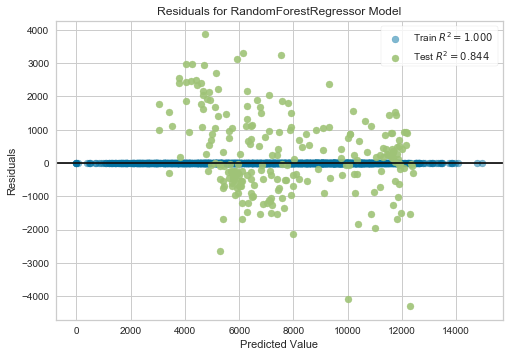

In [20]:
from yellowbrick.regressor import ResidualsPlot

resplot = ResidualsPlot(rf_best)

resplot.fit(Xtrain, ytrain)
resplot.score(Xtest, ytest)
g = resplot.poof()

What does our prediction error look like?

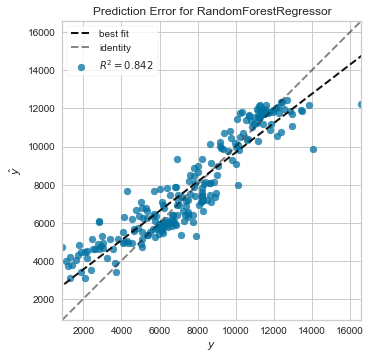

In [21]:
from yellowbrick.regressor import PredictionError

prederr = PredictionError(rf_best)

prederr.fit(Xtrain, ytrain)
prederr.score(Xtest, ytest)
g = prederr.poof()

Next, we pull out our fitted values (yhat) and actuals (ytest) to see how they compare.

We also calculate our residuals by subtracting our fitted values from the actuals.

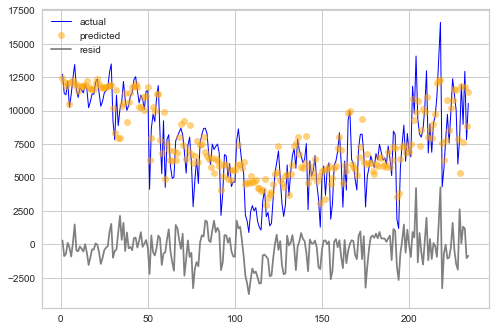

In [22]:
import matplotlib.pyplot as plt

rf_best.fit(Xtrain, ytrain)

yhat = rf_best.predict(Xtest)
resid = ytest - yhat

data = pd.DataFrame({'t': range(1, len(yhat) + 1), 
                     'ytest': ytest, 
                     'yhat': yhat,
                     'resid': resid})

plt.plot('t', 'ytest', data=data, color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, color='orange', marker='o', linestyle="None", label='predicted', alpha=0.5)
plt.plot('t', 'resid', data=data, color='gray')
plt.legend()
plt.show()


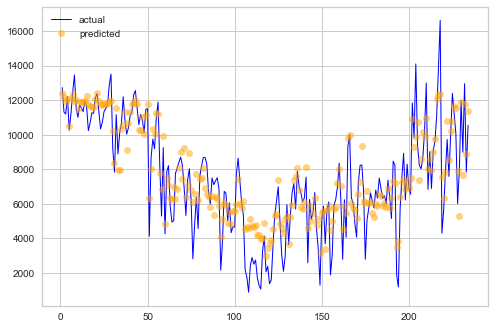

In [23]:
plt.plot('t', 'ytest', data=data, color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, color='orange', marker='o', linestyle="None", label='predicted', alpha=0.5)
plt.legend()

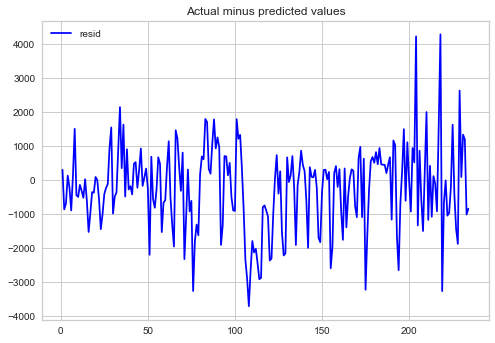

In [24]:
plt.title('Actual minus predicted values')
plt.plot('t', 'resid', data=data, color='blue')
plt.legend()

In [25]:
# On net, actuals minus predicted is negative
# This means our model overpredicted on average

data['resid'].sum()

-58962.65285714285

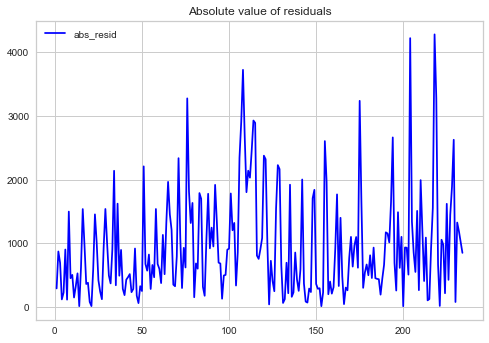

In [26]:
data['abs_resid'] = np.abs(resid)

plt.title('Absolute value of residuals')
plt.plot('t', 'abs_resid', data=data, color='blue')
plt.legend()

In [27]:
from sklearn.externals import joblib
joblib.dump(rf_best, 'rf_total.pkl') 
# To get it out later,
# model = joblib.load('rf_total.pkl') 

['rf_total.pkl']

In [28]:
end_time = (time.perf_counter() - start_time)/60
print("This notebook took {:0.2f} minutes to run".format(end_time))

This notebook took 33.52 minutes to run
